## Loading the datasets and image feature extraction using VGG 16 

In [1]:
import numpy as np
from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
import pandas as pd
import os

# Loading the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

# Function to resize an image based on VGG16 input size
def resize_image(image, target_size=(224, 224)):
    img = image.resize(target_size)
    return img

# Function to extract features from an image using the VGG16 model
def extract_features(image_path):
    img = Image.open(image_path)  # Open the image using PIL
    img = img.convert('RGB')  # Convert the image to RGB (if it's grayscale)
    img = resize_image(img)  # Resize the image
    x = image.img_to_array(img)  # Convert image to array
    x = np.expand_dims(x, axis=0)  # Add an extra dimension to match VGG16 input shape
    x = preprocess_input(x)  # Preprocess the input (e.g., normalization)

    features = model.predict(x)  # Extract features using VGG16

    return features.flatten()  # Flatten the features to a 1D array


# Loading the movie data including IMDb ID, link, local image path, and other attributes
data = pd.read_csv("C:/Users/KIIT/Downloads/archive (1)/movies.csv")  # Replace with the actual path to your movie data CSV file

# Specify the path to the image folder
image_folder = "C:/Users/KIIT/Downloads/archive (1)/images/images" # Replace with the path to your image folder

duplicate_imdb_ids = data['imdbId'].duplicated()
print("Number of duplicate IMDb IDs:", duplicate_imdb_ids.sum())
data = data.drop_duplicates(subset='imdbId', keep='first')

# Extract visual features for each image and store in a list
visual_features = None  # Initialize as None
missing_images = []

for index, row in data.iterrows():
    imdb_id = str(row['imdbId'])  # Convert the IMDb ID to a string
    image_filename = imdb_id + '_.jpg'  # Append the underscore and the file extension to the IMDb ID
    image_path = os.path.join(image_folder, image_filename)  # Concatenate the image folder path with the modified image filename
    image_path = os.path.normpath(image_path)  # Normalize the path for OS compatibility
    
    print(f"Processing image: {image_filename}")

    if os.path.exists(image_path):
        features = extract_features(image_path)
        if visual_features is None:
            visual_features = features.reshape(1, -1)
        else:
            features = features.reshape(1, -1)
            visual_features = np.concatenate((visual_features, features), axis=0)
        print("Features extracted successfully.")
    else:
        missing_images.append(image_path)
        print("Image not found.")

    print("")

# Convert the list of missing images to a DataFrame
missing_images_df = pd.DataFrame(missing_images, columns=['image_path'])

# Merge the missing images DataFrame with the original data using IMDB ID as the key
combined_data = pd.merge(data, missing_images_df, left_on='imdbId', right_index=True, how='left')



image_folder_path = 'C:/Users/KIIT/Downloads/archive (1)/images/images/'  # Replace with the base folder path

# Update the image path column
combined_data['image_path'] = image_folder + combined_data['image_path']


# Print the combined data
print(combined_data)


Number of duplicate IMDb IDs: 97
Processing image: 114709_.jpg
1/1 [==============================] - 1s 622ms/step
Features extracted successfully.

Processing image: 113497_.jpg
1/1 [==============================] - 0s 150ms/step
Features extracted successfully.

Processing image: 113277_.jpg
1/1 [==============================] - 0s 152ms/step
Features extracted successfully.

Processing image: 114319_.jpg
1/1 [==============================] - 0s 147ms/step
Features extracted successfully.

Processing image: 114576_.jpg
1/1 [==============================] - 0s 185ms/step
Features extracted successfully.

Processing image: 113189_.jpg
1/1 [==============================] - 0s 157ms/step
Features extracted successfully.

Processing image: 112346_.jpg
1/1 [==============================] - 0s 147ms/step
Features extracted successfully.

Processing image: 112896_.jpg
1/1 [==============================] - 0s 193ms/step
Features extracted successfully.

Processing image: 113987_.jpg
1

In [3]:
print(combined_data.head())

   imdbId                           Imdb Link                Title  \
0  114709  http://www.imdb.com/title/tt114709     Toy Story (1995)   
1  113497  http://www.imdb.com/title/tt113497       Jumanji (1995)   
2  113277  http://www.imdb.com/title/tt113277          Heat (1995)   
3  114319  http://www.imdb.com/title/tt114319       Sabrina (1995)   
4  114576  http://www.imdb.com/title/tt114576  Sudden Death (1995)   

   IMDB Score                       Genre    local_image_path image_path  
0         8.3  Animation;Adventure;Comedy  images/114709_.jpg        NaN  
1         6.9     Action;Adventure;Family  images/113497_.jpg        NaN  
2         8.2          Action;Crime;Drama  images/113277_.jpg        NaN  
3         6.3                Comedy;Drama  images/114319_.jpg        NaN  
4         5.7       Action;Crime;Thriller  images/114576_.jpg        NaN  


## Review dataset. merging the movies datset with the review dataset.

In [2]:
# Load the review dataset
review_data_path = "C:/Users/KIIT/Downloads/archive (1)/reviews.csv"  # Replace with the actual path to the review dataset
review_df = pd.read_csv(review_data_path)

In [3]:
# Rename the column in the review dataset
review_df = review_df.rename(columns={'movie': 'Title'})

# Drop duplicate movie titles from review_df
review_df = review_df.drop_duplicates(subset='Title')

# Merge the movie and review datasets based on the common identifier (Title)
merged_df = pd.merge(combined_data, review_df, on='Title')
print(merged_df.shape)

(4071, 15)


# Textual Feature Extraction

In [4]:
# Textual feature extraction

# Combine the review summary and review detail into a single text feature
merged_df['review_text'] = merged_df['review_summary'] + ' ' + merged_df['review_detail']

# Sentiment analysis
from textblob import TextBlob
merged_df['review_sentiment'] = merged_df['review_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

In [62]:
print(merged_df.shape)

(4071, 17)


In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing subsets
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Print the shapes of the subsets
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)


Training set shape: (3256, 17)
Testing set shape: (815, 17)


In [6]:
# Filter the DataFrame to include only the movies with available visual features
filtered_df = merged_df[:len(visual_features)].copy()

# Extract the visual features for movies present in the DataFrame
visual_features_reshaped = visual_features.reshape(len(visual_features), -1)

# Concatenate the textual and visual features
concatenated_features = np.hstack((filtered_df[['review_sentiment']].values, visual_features_reshaped))

# Update the filtered DataFrame with the concatenated features
filtered_df.loc[:, 'concatenated_features'] = list(concatenated_features)

# Print the shape of the filtered DataFrame
print("Filtered DataFrame shape:", filtered_df.shape)


Filtered DataFrame shape: (4071, 18)


In [9]:
print(filtered_df['imdbId'].unique())
print(filtered_df.head())


[ 114709  113497  113277 ... 4547056 4361050 1679335]
   imdbId                           Imdb Link                Title  \
0  114709  http://www.imdb.com/title/tt114709     Toy Story (1995)   
1  113497  http://www.imdb.com/title/tt113497       Jumanji (1995)   
2  113277  http://www.imdb.com/title/tt113277          Heat (1995)   
3  114319  http://www.imdb.com/title/tt114319       Sabrina (1995)   
4  114576  http://www.imdb.com/title/tt114576  Sudden Death (1995)   

   IMDB Score                       Genre    local_image_path image_path  \
0         8.3  Animation;Adventure;Comedy  images/114709_.jpg        NaN   
1         6.9     Action;Adventure;Family  images/113497_.jpg        NaN   
2         8.2          Action;Crime;Drama  images/113277_.jpg        NaN   
3         6.3                Comedy;Drama  images/114319_.jpg        NaN   
4         5.7       Action;Crime;Thriller  images/114576_.jpg        NaN   

   review_id             reviewer  rating  \
0  rw1166979           

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendation(movie_id, top_k=5):
    # Get the index of the movie in the DataFrame
    movie_index = filtered_df[filtered_df['imdbId'] == movie_id].index[0]

    # Get the similarity scores for the movie
    similarity_scores = cosine_similarity(filtered_df['concatenated_features'].tolist())
    movie_scores = similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs of the top-k recommended movies
    top_k_recommendations = filtered_df.loc[top_indices, 'imdbId'].tolist()

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = content_based_recommendation(movie_id, top_k=5)

print("Top 5 recommended movies:")
for imdb_id in top_k_recommendations:
    movie_title = filtered_df.loc[filtered_df['imdbId'] == imdb_id, 'Title'].values[0]
    print(imdb_id, "-", movie_title)


Top 5 recommended movies:
114709 - Toy Story (1995)
101414 - Beauty and the Beast (1991)
445922 - Across the Universe (2007)
97659 - Kickboxer (1989)
993842 - Hanna (2011)


## Using Cosine similarity to calculate the similarity score

In [72]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

def content_based_recommendation(movie_id, top_k=5):
    # Get the index of the movie in the DataFrame
    movie_index = filtered_df[filtered_df['imdbId'] == movie_id].index[0]

    # Get the textual and visual features for all movies
    features = filtered_df['concatenated_features'].tolist()

    # Compute the cosine similarity between the features
    similarity_scores = cosine_similarity(features)

    # Get the similarity scores for the movie
    movie_scores = similarity_scores[movie_index]

    # Scale the cosine similarity scores between 1 and 5 to match the rating scale
    scaler = MinMaxScaler(feature_range=(1, 5))
    scaled_scores = scaler.fit_transform(movie_scores.reshape(-1, 1)).flatten()

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-scaled_scores)[:top_k]

    # Get the IMDb IDs of the top-k recommended movies
    top_k_recommendations = filtered_df.loc[top_indices, 'imdbId'].tolist()

    return top_k_recommendations

# Example usage:
movie_title = "Mortal Kombat (1995)"  # Specify the movie title for which you want recommendations
movie_id = filtered_df.loc[filtered_df['Title'] == movie_title, 'imdbId'].values[0]
top_k_recommendations = content_based_recommendation(movie_id, top_k=5)

print("Top 5 recommended movies for", movie_title + ":")
for imdb_id in top_k_recommendations:
    movie_title = filtered_df.loc[filtered_df['imdbId'] == imdb_id, 'Title'].values[0]
    print(imdb_id, "-", movie_title)


Top 5 recommended movies for Mortal Kombat (1995):
113855 - Mortal Kombat (1995)
66473 - Tora! Tora! Tora! (1970)
1020072 - Selma (2014)
120201 - Starship Troopers (1997)
2180411 - Into the Woods (2014)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity matrix
similarity_matrix = cosine_similarity(concatenated_features)

# Print the shape of the similarity matrix
print("Similarity Matrix shape:", similarity_matrix.shape)


Similarity Matrix shape: (4071, 4071)


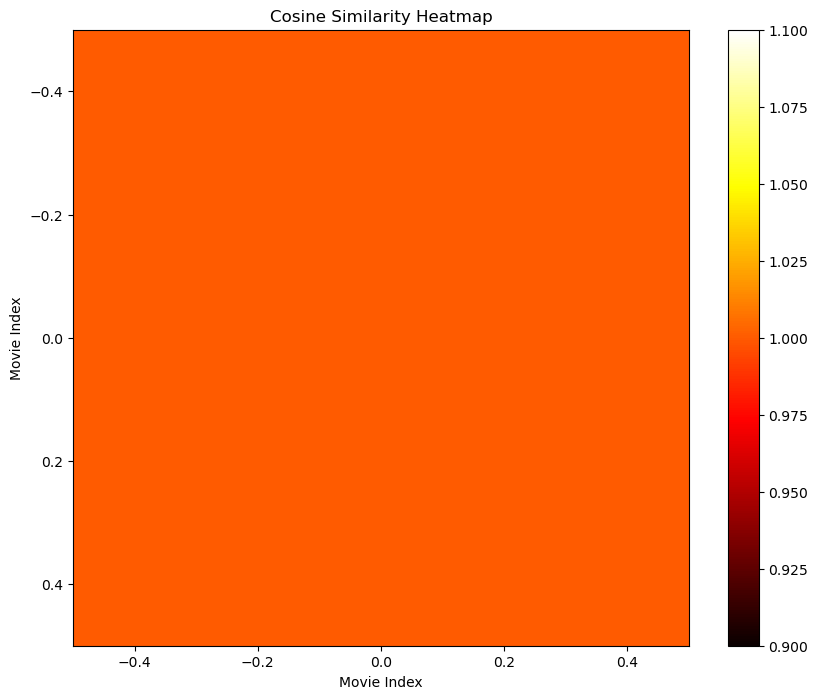

In [9]:
import matplotlib.pyplot as plt

# Compute the cosine similarity between the features
similarity_scores = cosine_similarity(features)

# Generate the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(similarity_scores, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Cosine Similarity Heatmap")
plt.xlabel("Movie Index")
plt.ylabel("Movie Index")
plt.show()


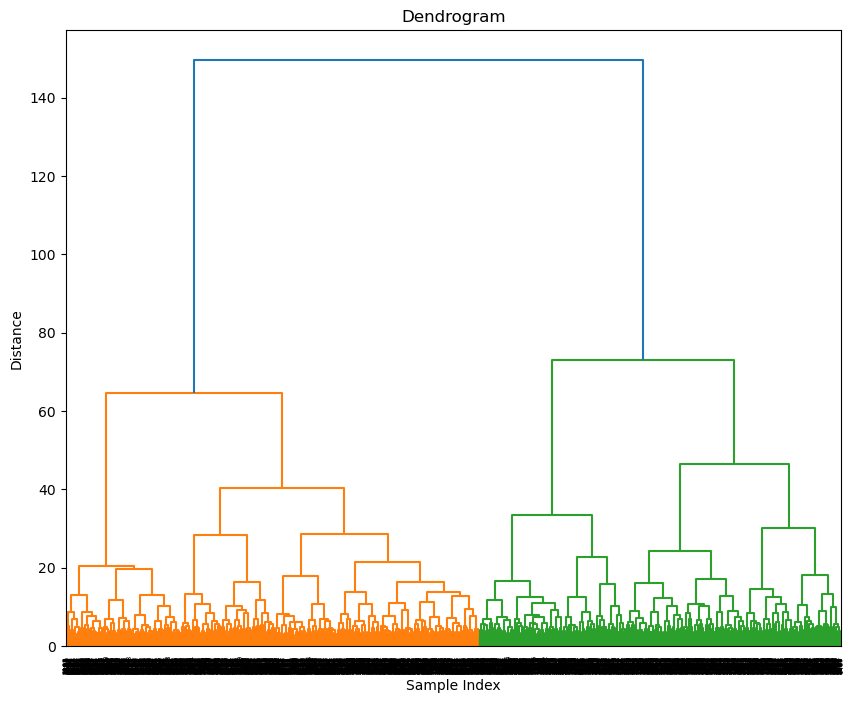

In [15]:
from scipy.cluster.hierarchy import ward, dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the dendrogram
linkage_matrix = linkage(similarity_matrix, method='ward')

plt.figure(figsize=(10, 8))
dendrogram(linkage_matrix)
plt.title("Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


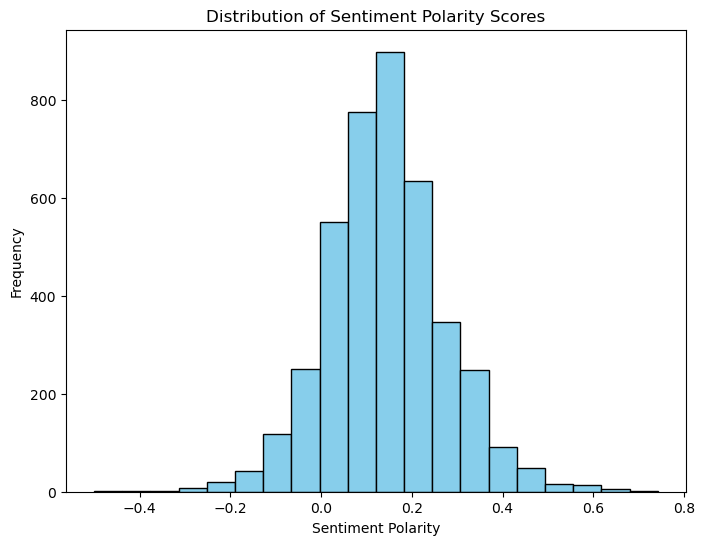

In [11]:
import matplotlib.pyplot as plt

# Plot the sentiment polarity scores
plt.figure(figsize=(8, 6))
plt.hist(merged_df['review_sentiment'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity Scores')
plt.show()


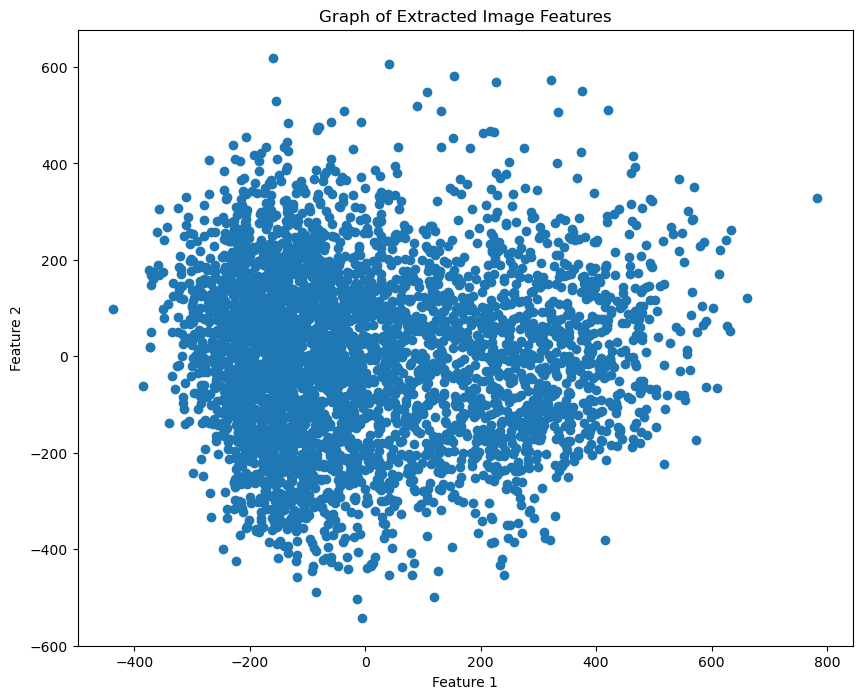

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the dimensionality of the visual features to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(visual_features)

# Plot the reduced features
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.title("Graph of Extracted Image Features")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
